<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Diego Alvarez Jeria</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401(1).pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [2]:
import cv2
import os
import zipfile
import numpy as np
from timeit import default_timer as timer
from collections import defaultdict
import matplotlib.pyplot as plt

start = timer()
# Descomprimir archivo ZIP 
zip_path = 'batch_june2024.zip'
extract_folder = 'meta_surf'  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

folder = os.path.join(extract_folder, 'processed512')

# Listar los nombres de archivo antes de cargar imágenes 
image_filenames = [
    fn for fn in os.listdir(folder)
    if fn.lower().endswith(('.png'))
]

# Contar cuántas imagenes hay de cada tipo 
def contador_tipo_filenames(filenames):
    count_circ  = sum(fn.startswith('circ')  for fn in filenames)
    count_box   = sum(fn.startswith('box')   for fn in filenames)
    count_cross = sum(fn.startswith('cross') for fn in filenames)
    return count_circ, count_box, count_cross

count_circ, count_box, count_cross = contador_tipo_filenames(image_filenames)
count_total = len(image_filenames)

print(f'Número de imágenes circle: {count_circ}')
print(f'Número de imágenes box: {count_box}')
print(f'Número de imágenes cross: {count_cross}')
print(f'Número total de imágenes: {count_total}')

Número de imágenes circle: 4416
Número de imágenes box: 3989
Número de imágenes cross: 5923
Número total de imágenes: 14328


## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [3]:
# Cargar plantillas en gris y float32
templates = {
    name: cv2.imread(f'{name}_template.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
    for name in ['cross', 'box', 'circ']
}


# Cargar imágenes en escala de grises y float32 
images_gray32 = {}
for filename in image_filenames:
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    images_gray32[filename] = img




## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [4]:
# Normalizar templates a [0, 1]
for name, tmpl in templates.items():
    min_val = np.min(tmpl)
    max_val = np.max(tmpl)
    if max_val > min_val:
        templates[name] = (tmpl - min_val) / (max_val - min_val)
    else:
        templates[name] = np.zeros_like(tmpl)


# Normalizar imágenes a [0, 1] 
for filename, img in images_gray32.items():
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        images_gray32[filename] = (img - min_val) / (max_val - min_val)
    else:
        images_gray32[filename] = np.zeros_like(img)  


# Pre‑calcula FFT de plantillas (padd a tamaño de imagen) 
# Tomamos la primera imagen para conocer el tamaño destino
H, W = next(iter(images_gray32.values())).shape
fft_templates = {}
for name, tmpl in templates.items():
    th, tw = tmpl.shape
    pad = np.zeros((H, W), np.float32)
    pad[:th, :tw] = tmpl                
    fft_templates[name] = np.fft.fft2(pad)







## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

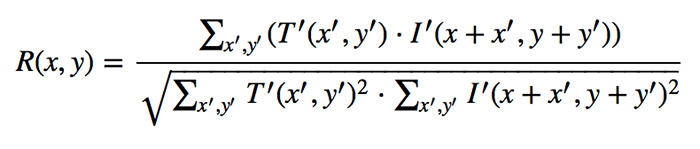

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia. 
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [5]:
#  Matching Dif. Absoluta (SAD)
results = defaultdict(dict)

for fname, img in images_gray32.items():
    best_label_sad, best_score_sad = None, np.inf
    for name, tmpl in templates.items():
        res = cv2.matchTemplate(img, tmpl, method=cv2.TM_SQDIFF)  # SAD
        score = res.min()                                         # menor es mejor
        if score < best_score_sad:
            best_score_sad, best_label_sad = score, name
    results[fname]['diff_abs'] = (best_label_sad, best_score_sad)


# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.



======= Reporte con normalización [0, 1] =======
Archivo: box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-0_80-90.png
  Dif. abs →   box | score = 23.62 | normalizado = 0.3189
Archivo: box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-100_80-90.png
  Dif. abs →   box | score = 21.28 | normalizado = 0.2228
Archivo: box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-101_80-90.png
  Dif. abs →   box | score = 20.71 | normalizado = 0.1992
Archivo: box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-102_80-90.png
  Dif. abs →   box | score = 22.19 | normalizado = 0.2602
Archivo: box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-103_80-90.png
  Dif. abs →   box | score = 23.06 | normalizado = 0.2958
Archivo: box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-104_80-90.png
  Dif. abs →   box | score = 20.95 | normalizado = 0.2090
Archivo: box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-105_80-90.png
  Dif. abs →   box | score = 2

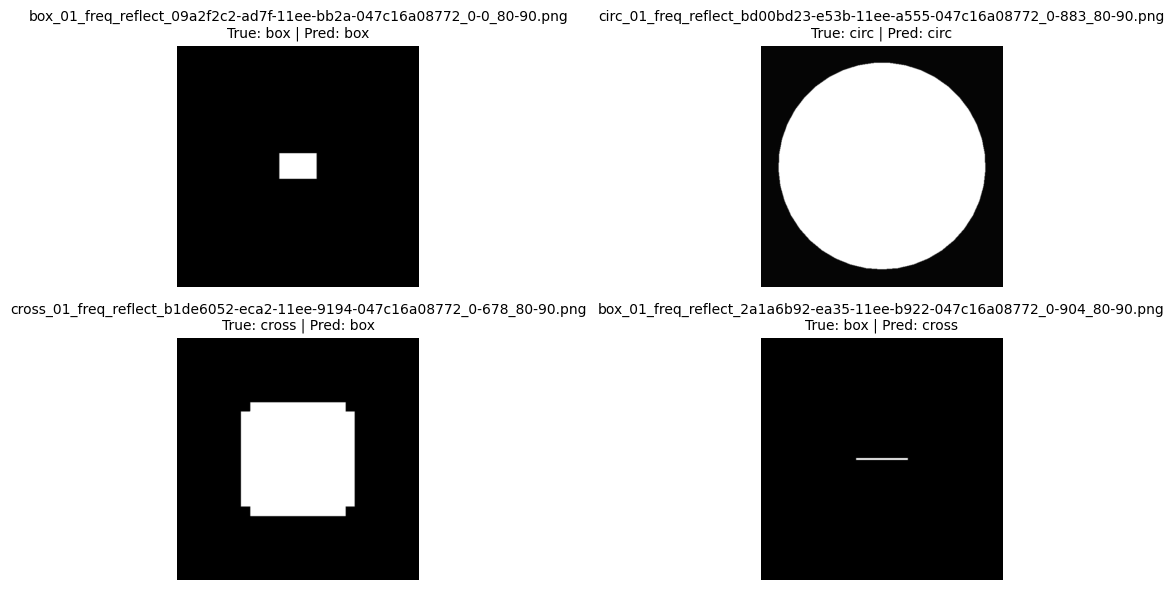

In [6]:
# Reporte con normalización 
diff_scores = [d['diff_abs'][1] for d in results.values()]
min_score = min(diff_scores)
max_score = max(diff_scores)


eps = 1e-8

print("\n======= Reporte con normalización [0, 1] =======")
for fname, d in results.items():
    score = d["diff_abs"][1]
    score_norm = (score - min_score) / (max_score - min_score + eps)
    print(f'Archivo: {fname}')
    print(f'  Dif. abs → {d["diff_abs"][0]:>5} | score = {score:.4g} | normalizado = {score_norm:.4f}')

import matplotlib.pyplot as plt
# Lista los nombres de archivo disponibles
print("Total de imágenes clasificadas:", len(results))
print("Ejemplos disponibles:", list(results.keys())[:10], "...")

# === Especifica tus 4 archivos aquí ===
ejemplos_verdaderos = ['box_01_freq_reflect_09a2f2c2-ad7f-11ee-bb2a-047c16a08772_0-0_80-90.png', 'circ_01_freq_reflect_bd00bd23-e53b-11ee-a555-047c16a08772_0-883_80-90.png']   # Cambia estos por tus casos verdaderos
ejemplos_falsos     = ['cross_01_freq_reflect_b1de6052-eca2-11ee-9194-047c16a08772_0-678_80-90.png', 'box_01_freq_reflect_2a1a6b92-ea35-11ee-b922-047c16a08772_0-904_80-90.png']  # Cambia estos por tus casos con error

ejemplos_a_mostrar = ejemplos_verdaderos + ejemplos_falsos

# === Mostrar imágenes ===
plt.figure(figsize=(15, 6))

for i, fname in enumerate(ejemplos_a_mostrar):
    

    img = images_gray32[fname]
    pred = results[fname]['diff_abs'][0]
    true = fname.split('_')[0]  # Basado en el nombre del archivo

    plt.subplot(2, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{fname}\nTrue: {true} | Pred: {pred}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [7]:



end = timer()

print((end - start)/60)



3.9600071116667097
